In [1]:
import os
import torch
import numpy as np

from model import VerseFxClassifier

saved_checkpoint = f"moonlit-flower-278.ckpt"

checkpoint = torch.load(saved_checkpoint, map_location="cpu")

# Point this to a path that contains a 'fxall_labels.csv' file as well as
# a 'raw' folder with all vertebrae.
checkpoint['hyper_parameters']['dataset_path'] = '/mnt/polyaxon/data1/verse/spline_volumes_96'

model = VerseFxClassifier.load_from_checkpoint(saved_checkpoint, 
                                               hparams=checkpoint['hyper_parameters'],
                                               map_location="cuda")

model.eval()

from data import VerseDataModule

class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

dm = VerseDataModule(hparams=AttrDict(checkpoint['hyper_parameters']), verse_only=True)
dm.prepare_data()

dm.setup(stage="test")

In [ ]:
from netdissect_interface import MalignantNet3dDissectResults

# immediate layer before classifier is hooked
layername = 'down_tr512'

dissector = MalignantNet3dDissectResults(model.backbone.float(), dm.datasets['test'], '/mnt/polyaxon/data1/verse/spline_volumes_96', layername)

In [ ]:
if dissector.topk is None:
    dissector.compute_topk_imgs('mean', 'pos')

unit_images = dissector.iv.masked_single_image_for_topk(dissector._compute_activations, dissector.ds, dissector.topk, k=25, **{"num_workers": 10, "pin_memory":True})

In [ ]:
import numpy as np
import os
from monai.transforms import CenterSpatialCrop
from netdissect import nethook, imgviz, show, upsample, tally, pbar
from netdissect import setting
from torch.utils.data import DataLoader
from tqdm import tqdm

if dissector.unit_images is None:
    # one may also compute individual images or NIfTIs for each unit
    #dissector.compute_top_unit_imgs(data="pos")
    #dissector.compute_top_unit_nifti(data="pos")
    dissector.compute_top_unit_collage(data="pos")
    
# 0.99-quantile activations for each filter
level_at_99 = dissector.rq.quantiles(0.99)[None, :, None, None, None].cuda()

In [4]:
# Generate collage-like overview of each unit's activation (as seen in the paper)
# and determine positive correlation ranks to be inlined in app.py

# positive samples only
# returns (n, 512) tensor indicating if a unit was activated for an image in the batch
def get_batch_indicators(**batch):
    if (batch["fx"] != 1): return None
    
    image_batch = batch["image"].cuda()
    _ = dissector.model(image_batch)
    
    acts = dissector.model.retained_layer(dissector.layername)
    
    return torch.amax((acts > level_at_99), dim=(2,3,4)).float()[0][:, None]

# negative samples with incorrect prediction only
# returns (n, 512) tensor indicating if a unit was activated for an image in the batch
"""
def get_batch_indicators(**batch):
    if (batch["fx"] != 0): return None
    
    image_batch = batch["image"].cuda()
    _, preds = model.logits_to_predictions(dissector.model(image_batch))
    
    mask = (batch["fx"].cuda() != preds)
    acts = dissector.model.retained_layer(dissector.layername)

    return (mask * torch.amax((acts > level_at_99), dim=(2,3,4)).float())[0][:, None]
"""

stack = torch.cat([x for x in [get_batch_indicators(**batch) for batch in tqdm(DataLoader(dissector.ds))] if x is not None], dim=1)
mean_acts = stack.mean(dim=1)

pos_activation_unit_label_99 = sorted([(
    unit, "fracture", activation.item())
    for unit, activation in enumerate(mean_acts)],
    key=lambda x: x[-1], reverse=True)

for i, (unit, label, score) in enumerate(pos_activation_unit_label_99):
    dissector.write_collage_unit(unit, i, custom_suffix="positives")
    # dissector.write_nifti_unit(unit, i, custom_suffix="positives")
    
# the result is inlined in app.py
print({unit: corr_rank for corr_rank, (unit, _, _) in enumerate(pos_activation_unit_label_99})

100%|███████████████████████████████████████████████████████████████████████████| 602/602 [00:08<00:00, 68.89it/s]


In [ ]:
# Generate a grid of five images showing the slices of the individual top images
dissector.compute_topk_imgs("mean", "pos")
unit_single_images = dissector.iv.masked_single_images_for_topk(
            dissector._compute_activations,
            dissector.ds,
            dissector.topk,
            k=25,
            num_workers=10,
            per_row=5,
            pin_memory=True)

In [6]:
len(unit_single_images)

512

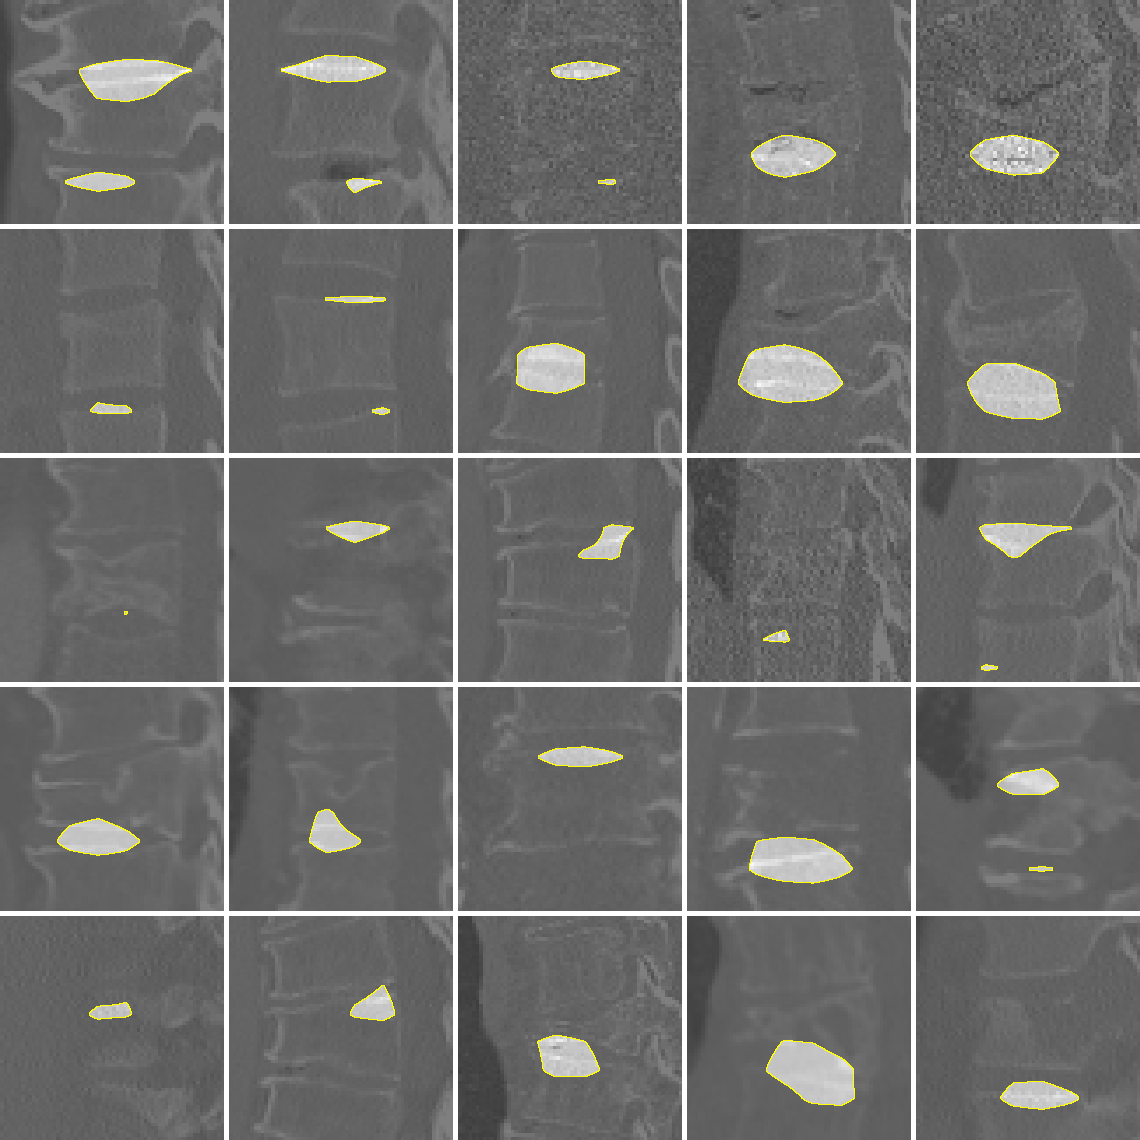

In [17]:
unit_single_images[322]

In [ ]:
# Write concepts of each detector unit into the folder "concepts"

import matplotlib.pyplot as plt
import PIL.Image

number_of_concepts = 8

for unit in range(unit_images.shape[0]):
    idxs = []
    # search the unit's top 25 images for suitable images
    for i in range(25):
        image = unit_images[unit, i, 0]
        # identify border pixels produced by dissector.iv.masked_single_image_for_topk
        mask = (image[:, :, 0] > 220) & (image[:, :, 1] > 220) & (image[:, :, 1] > 90)
        # only select those samples where something can be seen
        if (mask.sum() > 50):
            PIL.Image.fromarray(image.numpy(), mode='RGB').save(f"concepts/{unit}_{i}.png")
            idxs.append(i)
        if len(idxs) == number_of_concepts:
            break
    if len(idxs) < number_of_concepts:
        # print those units that did not yield the desired number of concepts
        print(f"{unit}: {len(idxs)}")

In [ ]:
# Determine the statistically significant thresholds for each detector unit
# to be inlined in app.py

# gather 0.99-quantile activations for each filter
level_at_99 = dissector.rq.quantiles(0.99)[None, :, None, None, None].cuda()

# choose a dummy image to provide the acts parameter to dissector.iv.level_for
# it will not be used as we have already computed the quantiles
image = torch.tensor(dm.datasets['test'][122]["image"])[None, ...]

image_batch = image.cuda() if torch.cuda.is_available() else image
imgt = image_batch[0]
_ = dissector.model(image_batch)
acts = dissector.model.retained_layer(dissector.layername)[0]

levels = [dissector.iv.level_for(acts[unit], unit) for unit in range(acts.shape[0])]

# the result of this cell is inlined in app.py
print(levels)